In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Una vez clonado el Github de ImageBind: https://github.com/facebookresearch/ImageBind
!pip install -r './ImageBind/requirements.txt'

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
from torchvision.io import read_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import h5py
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, precision_score, roc_curve, roc_auc_score
from tqdm import tqdm
from torch.nn.parallel import DataParallel
import itertools

# Dataset

In [ ]:
path = './data.csv'
df = pd.read_csv(path)
df

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Affe83,happy monkey,1.422733e+09,i.imgur.com,True,2uby3q,https://external-preview.redd.it/GCNDYynaFBipK...,NaN,2.0,2,photoshopbattles,PsBattle: Happy Monkey,0.67,1,0,0
1,hasan_raza,illegal immigrant who was allowed to stay in u...,1.486725e+09,cbc.ca,True,5t6oph,https://external-preview.redd.it/2QBSXMd7WK4Fh...,NaN,1.0,1,usnews,Illegal immigrant who was allowed to stay in U...,0.53,1,0,0
2,ViralGameover,moonshine dispenser rusty pump on the left out...,1.550633e+09,i.redd.it,True,asjc45,https://preview.redd.it/t9xpj1fh7nh21.jpg?widt...,NaN,3.0,15,mildlyinteresting,Moonshine dispenser (rusty pump on the left) o...,0.85,1,0,0
3,nerdyhusband,umm maybe not,1.552531e+09,i.redd.it,True,b0uzk8,https://preview.redd.it/9dosrswxyzl21.jpg?widt...,NaN,4.0,7,mildlyinteresting,Umm... maybe not?,0.65,1,0,0
4,SouthPawXIX,the airport has a bathroom for traveling dogs,1.565874e+09,i.redd.it,True,cqpgm7,https://preview.redd.it/7vp9l76b1mg31.jpg?widt...,NaN,4.0,20,mildlyinteresting,The airport has a bathroom for traveling dogs,0.93,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,yngail,the running man,1.503957e+09,i.imgur.com,True,6wmqcc,https://external-preview.redd.it/GQPHude6IBjd9...,NaN,1.0,2,photoshopbattles,PsBattle: the running man,0.75,1,0,0
99996,AdviceAnimals_SS,when i spend too much time to get out please,1.440821e+09,i.imgur.com,True,3it7ba,https://external-preview.redd.it/W7fHspeCDooIG...,NaN,19.0,13,subredditsimulator,When I spend too much time to get out please,0.89,0,2,3
99997,schnexy_man9,bloomington mcdonalds employee charged with ba...,1.553801e+09,fox59.com,True,b6n4m5,https://external-preview.redd.it/Sx2aXZdWimGS5...,NaN,2.0,18,nottheonion,Bloomington McDonald’s employee charged with b...,0.88,1,0,0
99998,humanmanguy,former nokia ceo founds newkia aims to create ...,1.378476e+09,androidauthority.com,True,1luqdh,https://external-preview.redd.it/CfzfFRvM3s1IO...,NaN,3.0,10,nottheonion,"Former Nokia CEO founds Newkia, aims to create...",0.71,1,0,0


In [ ]:
NUM_CLASES = 5

In [ ]:
#Para la tarea de clasificación de 5 clases, se eliminan las instancias de la categoría True
if NUM_CLASES == 5:
  df = df[df['6_way_label'] != 0].reset_index(drop=True)
  valores_unicos = df['6_way_label'].unique()
  valores_unicos = sorted(valores_unicos)
  mapeo = {valor: nuevo_valor for valor, nuevo_valor in zip(valores_unicos, range(len(valores_unicos)))}
  df['6_way_label'] = df['6_way_label'].map(mapeo)

In [ ]:
class FakedditTextImageDataset(Dataset):

    def __init__(self, text_data, img_file, transform=None, n_labels):
        self.data = text_data
        self.hf = h5py.File(img_file, 'r')
        self.transform = transform
        self.image_names = list(self.hf.keys())

        if n_labels == 5:
            self.image_names = [id for id in self.image_names if id in self.data['id'].values]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_id = self.image_names[idx]
        image = self.hf[image_id][:]
        image = Image.fromarray(image)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        if self.transform:
            image = self.transform(image)

        row = self.data.loc[self.data['id'] == image_id]

        text = row['clean_title'].values[0]
        two_way_label = row['2_way_label'].values[0]
        three_way_label = row['3_way_label'].values[0]
        six_way_label = row['6_way_label'].values[0]

        return {'text':text, 'image': image, 'two_way_label': two_way_label, 'three_way_label':three_way_label, 'six_way_label':six_way_label}

#Transformaciones aplicadas a las imágenes
data_transform = transforms.Compose(
    [
        transforms.Resize(
            224, interpolation=transforms.InterpolationMode.BICUBIC
        ),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

img_file = './image_file.h5'

fakeddit = FakedditTextImageDataset(df,img_file,data_transform)

train_size = 0.7
val_size = 0.1
test_size = 0.2

dataset_size = len(fakeddit)
train_size = int(train_size * dataset_size)
val_size = int(val_size * dataset_size)
test_size = dataset_size - train_size - val_size

torch.manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(fakeddit, [train_size, val_size, test_size])

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print('TRAIN: ', len(train_dataset))
print('VALIDATION: ', len(val_dataset))
print('TEST: ', len(test_dataset))

In [ ]:
train_features = train_dataset.__getitem__(0)

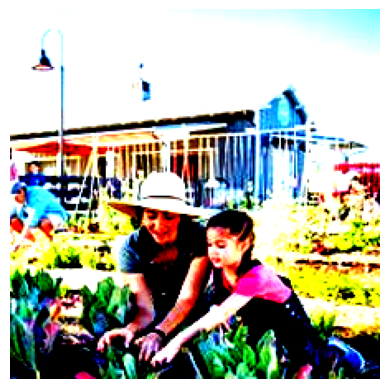

Text: swapping one word for cant will make you more successful in dieting and in life
2 Way Label: 0
3 Way Label: 2
6 Way Label: 4


In [ ]:
img = train_features['image'].detach().numpy()
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)
plt.axis('off')
plt.show()

print('Text:',train_features['text'])
print('2 Way Label:',train_features['two_way_label'])
print('3 Way Label:',train_features['three_way_label'])
print('6 Way Label:',train_features['six_way_label'])

# ARQUITECTURA 2

**ImageBind**

In [ ]:
%cd './ImageBind'
import data
from models import imagebind_model
from models.imagebind_model import ModalityType

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_bind = imagebind_model.imagebind_huge(pretrained=True)
for param in image_bind.parameters():
    param.requires_grad = False

**Modelo**

In [ ]:
class MLP(nn.Module):

    def __init__(self, dimx, hidden1, n_labels):
        super().__init__()

        self.actFunc = None

        self.dim_output = n_labels
        if self.dim_output == 2:
            self.actFunc = nn.Sigmoid()
            self.dim_output = 1
        else:
            self.actFunc = nn.LogSoftmax(dim=1)

        self.output1 = nn.Linear(dimx,hidden1)

        self.output2 = nn.Linear(hidden1,self.dim_output)

        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.actFunc(x)
        return x

class MyModel(nn.Module):

    def __init__(self, n_labels, input_mlp, hidden1, image_bind):
        super().__init__()

        self.model = DataParallel(image_bind)

        self.fc = DataParallel(MLP(input_mlp, hidden1, n_labels))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, images, text):
        inputs = {
            ModalityType.TEXT: data.load_and_transform_text(text, self.device),
            ModalityType.VISION: images,
        }

        with torch.no_grad():
            embeddings = self.model(inputs)

        combined_embedding = torch.cat((embeddings[ModalityType.VISION], embeddings[ModalityType.TEXT]), dim=1)

        output = self.fc.forward(combined_embedding)

        return output

class MyModel_extended(MyModel):

    def __init__(self, num_epochs, learning_rate, input_mlp, hidden1, label, n_labels, image_bind):
        super().__init__(n_labels, input_mlp, hidden1, image_bind)

        self.learning_rate = learning_rate
        self.optim = optim.Adam(self.parameters(), self.learning_rate)
        self.num_epochs = num_epochs
        self.criterion = None

        self.n_labels = n_labels
        if self.n_labels == 2:
            self.criterion = nn.BCELoss()
        else:
            self.criterion = nn.NLLLoss()

        self.loss_during_training = []
        self.valid_loss_during_training = []

        self.to(self.device)

        self.label = label

    def trainloop(self, train_dataloader, val_dataloader):
        for epoch in range(1, self.num_epochs + 1):

            self.train()
            train_loss = 0.0

            with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch}/{self.num_epochs} - Training", unit='batch') as pbar:

                for batch in train_dataloader:
                    images = batch['image'].to(self.device)
                    texts = batch['text']
                    labels = batch[self.label].to(self.device)

                    self.optim.zero_grad()

                    outputs = self.forward(images, texts)
                    if self.n_labels == 2:
                        outputs = outputs.view(-1)
                        labels = labels.float()

                    loss = self.criterion(outputs, labels)
                    train_loss += loss.item()

                    loss.backward()
                    self.optim.step()

                    pbar.update()

            self.loss_during_training.append(train_loss / len(train_dataloader))

            torch.save(self.state_dict(), "./modelo.pth")
            self.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with tqdm(total=len(val_dataloader), desc=f"Epoch {epoch}/{self.num_epochs} - Validation", unit='batch') as pbar:

                with torch.no_grad():

                    for batch in val_dataloader:

                        images = batch['image'].to(self.device)
                        texts = batch['text']
                        labels = batch[self.label].to(self.device)

                        outputs = self.forward(images, texts)
                        if self.n_labels == 2:
                            outputs = outputs.view(-1)
                            labels = labels.float()

                        loss = self.criterion(outputs, labels)
                        val_loss += loss.item()

                        if self.n_labels == 2:
                            predicted = torch.round(outputs)
                            total += labels.size(0)
                            correct += (predicted == labels).sum().item()
                        else:
                            _, predicted = torch.max(outputs.data, 1)
                            total += labels.size(0)
                            correct += (predicted == labels).sum().item()

                        pbar.update()

                    self.valid_loss_during_training.append(val_loss/len(val_dataloader))
                    val_accuracy = correct / total * 100

            print(f"Epoch [{epoch}/{self.num_epochs}] - Train Loss: {self.loss_during_training[-1]:.4f} - Val Loss: {self.valid_loss_during_training[-1]:.4f} - Val Accuracy: {val_accuracy:.2f}%")

    def evaluation_performance(self, dataloader):
        y_true = []
        y_pred = []
        probabilities = []
        results = {}

        self.eval()

        with torch.no_grad():

            with tqdm(total=len(dataloader), desc="Evaluation", unit='batch') as pbar:

                for batch in dataloader:

                    images = batch['image'].to(self.device)
                    texts = batch['text']
                    labels = batch[self.label].to(self.device)

                    outputs = self.forward(images, texts)
                    if self.n_labels == 2:
                        outputs = outputs.view(-1)
                        labels = labels.float()

                    if self.n_labels == 2:
                        predicted = torch.round(outputs)
                    else:
                        _, predicted = torch.max(outputs.data, 1)

                    batch_predictions = predicted.cpu().numpy()
                    batch_labels = labels.cpu().numpy()

                    y_pred.extend(batch_predictions)
                    y_true.extend(batch_labels)
                    probabilities.extend(outputs.cpu().numpy())

                    pbar.update()

        accuracy = accuracy_score(y_true, y_pred)
        if self.n_labels == 2:
            recall = recall_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred)
        else:
            m_recall = recall_score(y_true, y_pred, average="micro")
            m_f1 = f1_score(y_true, y_pred, average="micro")
            m_precision = precision_score(y_true, y_pred, average="micro")
            results['m_recall'] = m_recall
            results['m_f1'] = m_f1
            results['m_precision'] = m_precision
            recall = recall_score(y_true, y_pred, average=None)
            f1 = f1_score(y_true, y_pred, average=None)
            precision = precision_score(y_true, y_pred, average=None)

        confusion = confusion_matrix(y_true, y_pred)

        results['accuracy'] = accuracy
        results['recall'] = recall
        results['f1'] = f1
        results['confusion'] = confusion
        results['precision'] = precision

        return results

    def make_predictions(self, batch):
        self.eval()

        with torch.no_grad():
            images = batch['image'].to(self.device)
            texts = batch['text']
            labels = batch[self.label].to(self.device)

            outputs = self.forward(images, texts)
            if self.n_labels == 2:
                outputs = outputs.view(-1)
                labels = labels.float()

            if self.n_labels == 2:
                predicted = torch.round(outputs)
            else:
                _, predicted = torch.max(outputs.data, 1)

        return predicted

**Entrenamiento**

In [ ]:
input_mlp = 1024 + 1024
my_model = MyModel_extended(num_epochs=2,learning_rate=1e-3,input_mlp=input_mlp,hidden1=512,label='six_way_label',n_labels=NUM_CLASES,image_bind=image_bind)

In [ ]:
my_model.trainloop(train_dataloader,val_dataloader)

# Evaluacion

In [ ]:
input_mlp = 1024 + 1024
my_model = MyModel_extended(num_epochs=2,learning_rate=1e-3,input_mlp=input_mlp,hidden1=512,label='six_way_label',n_labels=NUM_CLASES,image_bind=image_bind)

In [ ]:
my_model.load_state_dict(torch.load("./modelo.pth"))

In [ ]:
results = my_model.evaluation_performance(test_dataloader)

In [ ]:
# Gráfica de la matriz de confusión
confusion = results['confusion']
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()

if NUM_CLASES == 2:
    classes = ["Fake", "True"]
elif NUM_CLASES == 3:
    classes = ["True", "Partially true", "Completely fake"]
else:
    classes = ["Satire/Parody", "Misleading", "Imposter", "False Connection", "Manipulated"]

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = confusion.max() / 2
for i, j in itertools.product(range(confusion.shape[0]), range(confusion.shape[1])):
    plt.text(j, i, format(confusion[i, j], 'd'),
             horizontalalignment="center",
             color="white" if confusion[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Valores reales')
plt.xlabel('Predicciones')
plt.show()

In [ ]:
if n == 2:
    roc_auc = results['roc_auc']
    print("AUC:", roc_auc)

    # Gráfica de la curva ROC
    fpr = results['roc_curve'][0]
    tpr = results['roc_curve'][1]
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()

**Predicción**

In [ ]:
iter_test = iter(test_dataloader)
batch_test = next(iter_test)
pred = my_model.make_predictions(batch_test)